##### Plot posterior pdf, lik function and prior for a given hyperparameter value

In [1]:
#!/usr/bin/python
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import scipy.optimize as sopt
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, math, sys
np.random.seed(88)
#os.system('rm *.pdf *.eps *.png');

In [2]:
K = 1 # number of kernels
polyPower = [0,1,2,3,4,5] # powers of polynomial
Nphi = len(polyPower) # number of basis
LogAlp0 = 5*np.array([1]*Nphi)
rCoeff = 1e-05*np.ones((1,Nphi)) 
sCoeff = 1e-05*np.ones((1,Nphi))
aCoeff  = np.ones((1,K)) 
muVec  = np.zeros((Nphi,K))
SigMat = np.zeros((Nphi,Nphi,K))

In [3]:
def basisFun(Xth,ith):
    return Xth**polyPower[ith]
rho0 = 100 # Starting error precision
Yobs = np.loadtxt('Ydata.dat') 
Xobs = np.loadtxt('Xdata.dat')
M = len(Yobs)
Phi = np.zeros((M,Nphi))
for i in range(0,M):
    for j in range(0,Nphi):
        Phi[i,j] = basisFun(Xobs[i],j)
pTpinv = la.inv(Phi.T@Phi)
mtmp = np.dot(Yobs,(np.eye(M) - Phi@pTpinv@Phi.T)@Yobs)
aCoeff[0,0] = np.power(rho0/(2*np.pi),0.5*(M-Nphi))*np.sqrt(la.det(pTpinv))*np.exp(-0.5*rho0*mtmp)
muVec[:,0] = pTpinv@Phi.T@Yobs
SigMat[:,:,0] = pTpinv/rho0 
# wtry = np.asarray([1.0,0.2,1.0,-0.3,0.2,-0.1])
# lika = np.log(st.multivariate_normal.pdf(Yobs,Phi@wtry,np.eye(M)/rho0))
# likb = np.log(aCoeff[0,0]*st.multivariate_normal.pdf(wtry,muVec[:,0],SigMat[:,:,0]))
# print(lika,likb)

In [4]:
def NSBL(logalpIN):
    alp = np.exp(logalpIN)
    A = np.diag(alp)
    Ainv = np.diag(1/alp)
    Bmat = np.zeros((Nphi,Nphi,K))
    Pmat = np.zeros((Nphi,Nphi,K))
    mVec = np.zeros((Nphi,K))
    wVec = np.zeros((1,K))
    vVec = np.zeros((Nphi,K))
    vbarVec = np.zeros((Nphi,1))
    jVec = np.zeros((Nphi,1))
    Hmat = np.zeros((Nphi,Nphi))
    for k in range(0,K):
        Bmat[:,:,k] = SigMat[:,:,k] + Ainv
        Pmat[:,:,k] = Ainv - Ainv@la.inv(Bmat[:,:,k])@Ainv
        mVec[:,k]   = Pmat[:,:,k]@la.inv(SigMat[:,:,k])@muVec[:,k]
        wVec[0,k]   = aCoeff[0,k]*st.multivariate_normal.pdf(muVec[:,k],[0]*Nphi,Bmat[:,:,k])
        for ii in range(0,Nphi):
            vVec[ii,k] = 0.5*(1.0 - alp[ii]*(Pmat[ii,ii,k] + mVec[ii,k]**2))
    evid = np.sum(wVec)
    wVec = wVec/evid
    objFun = np.log(evid) + np.dot(rCoeff[0,:],logalpIN) - np.dot(sCoeff[0,:],alp)
    for ii in range(0,Nphi):
        vbarVec[ii,0] = np.dot(wVec[0,:],vVec[ii,:])
        jVec[ii,0]   = vbarVec[ii,0] + rCoeff[0,ii] - sCoeff[0,ii]*alp[ii]
        for jj in range(0,ii):
            Hmat[ii,jj] = Hmat[jj,ii]
        for jj in range(ii,Nphi):
            tmpij = 1.0 if ii==jj else 0.0
            for k in range(0,K):
                Hmat[ii,jj] = Hmat[ii,jj] + wVec[0,k]*(alp[ii]*alp[jj]*(0.5*Pmat[ii,jj,k]**2 \
                                    + mVec[ii,k]*mVec[jj,k]*Pmat[ii,jj,k]) \
                                    + vVec[jj,k]*(vVec[ii,k] - vbarVec[ii,0]))
            Hmat[ii,jj] = Hmat[ii,jj] + tmpij*(vbarVec[ii,0] - sCoeff[0,ii]*alp[ii] - 0.5)
    return np.log(evid), objFun, jVec[:,0], Hmat

In [5]:
def myFun(xin):
    _, Otmp, Jtmp, _ = NSBL(xin)
    return -Otmp, -Jtmp
def myFunb(xin):
    _, Otmp, _, _ = NSBL(xin)
    return -Otmp
def myFunHess(xin):
    _, _, _, Htmp = NSBL(xin)
    return -Htmp

In [6]:
maxIter = 100
ftol = 1e-6
jtol = 1e-6
#res = sopt.minimize(myFun, LogAlp0, method='Newton-CG',jac=True, hess=myFunHess, \
#                    options={'maxiter':maxIter,'return_all': True,'xtol':ftol})
#res = sopt.minimize(myFun, LogAlp0, method='trust-ncg',jac=True, hess=myFunHess, \
#                    options={'maxiter':maxIter,'return_all': True,'gtol':jtol})
res = sopt.minimize(myFun, LogAlp0, method='trust-exact',jac=True, hess=myFunHess, \
                    options={'maxiter':maxIter,'return_all': True,'gtol':jtol})
print(res)
LogAlpIter = np.zeros((res.nit,Nphi))
fevalIter = np.zeros((res.nit,2))
for i in range(0,res.nit):
    LogAlpIter[i,:] = res.allvecs[i]
    fevalIter[i,0], fevalIter[i,1], _, _ = NSBL(LogAlpIter[i,:])
for i in range(0,Nphi):
    print(np.exp(res.x[i]))
np.savetxt('SBLnl_feval.dat',fevalIter[:,1])
print(LogAlpIter[0,:],fevalIter[0,0],fevalIter[0,1])
print('log-evid',fevalIter[-1,1])

 allvecs: [array([5., 5., 5., 5., 5., 5.]), array([4.10672935, 5.13184671, 5.13662078, 5.17020508, 5.19214514,
       4.68356798]), array([3.41662927, 3.3913437 , 5.57728641, 5.29251983, 5.26364219,
       4.1542739 ]), array([2.7105173 , 2.01524089, 6.97266989, 6.89526649, 6.76952726,
       1.54196358]), array([1.75602414, 1.38588497, 5.40792114, 5.36571539, 5.24019781,
       1.27904365]), array([0.93526492, 1.08225419, 3.31911132, 3.08942133, 2.86012916,
       1.43650718]), array([0.93526492, 1.08225419, 3.31911132, 3.08942133, 2.86012916,
       1.43650718]), array([0.36440041, 1.21516748, 3.21342778, 2.36455117, 1.22635217,
       2.27793037]), array([0.12144932, 1.25045165, 3.68724859, 2.45531394, 1.50067719,
       3.32862138]), array([0.12144932, 1.25045165, 3.68724859, 2.45531394, 1.50067719,
       3.32862138]), array([0.08062079, 1.23070715, 3.67922852, 2.96256944, 1.10650845,
       4.09360617]), array([0.09074483, 1.19298486, 4.39685705, 2.99614184, 1.15853183,
       4.

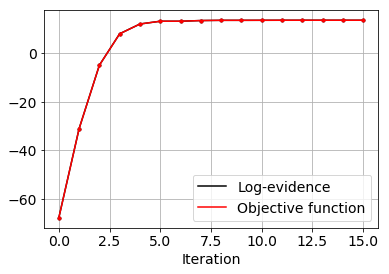

In [7]:
mpl.rcParams.update({'font.size':14})
plt.figure(1)
plt.plot(fevalIter[:,0],'k.')
plt.plot(fevalIter[:,0],'k-',label='Log-evidence')
plt.plot(fevalIter[:,1],'r.')
plt.plot(fevalIter[:,1],'r-',label='Objective function')
#plt.legend(loc='best', numpoints = 1)
plt.legend(loc='lower right', numpoints = 1)
plt.grid(True)
plt.xlabel('Iteration')
plt.savefig('figs/plot_feval.eps',bbox_inches='tight')